In [1]:
%cd /Users/rodrigo/Post-Grad/CC400/Repo

/Users/rodrigo/Post-Grad/CC400/Repo


In [2]:
import utils as ut

In [3]:
import utils as ut
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch_geometric
from torch_geometric.data import Data
from torch_geometric.utils import dense_to_sparse
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import cross_validate
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from neurocombat_sklearn import CombatModel

%matplotlib inline
sns.set(rc={'image.cmap': 'coolwarm'})

#from numba import jit,prange

import time
import os

SMALL_SIZE = 8
MEDIUM_SIZE = 14
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_macro': 'recall_macro',
          'f1' : 'f1_macro',
          'roc_auc' : 'roc_auc'}


In [4]:
print(torch.__version__)

1.13.1


In [5]:
print(torch_geometric.__version__)

2.1.0


In [6]:
df, phenotypic = ut.import_data(fisher=False)

group_fc = pd.read_csv(r'/Users/rodrigo/Post-Grad/CC400/Group_FC.csv').iloc[:,1]
df = df.join(pd.DataFrame(phenotypic['Gender']), how='left')

df['Age'] = phenotypic['Age']

from sklearn.utils import shuffle
df = shuffle(df, random_state=42)

df = df.dropna(axis=0)
df = df.reset_index()
df['Site'] = df['Institution'].astype('category')
df['Site'] = df['Site'].cat.codes

# TEST = df[df.Subject.isin(df['Subject'].unique()[-20:])].reset_index()
# X_TEST = TEST.drop(columns=['Institution', 'Subject', 'Run','Gender', 'Age', 'Site','index'])
# y_TEST = TEST.Gender

# df = df[~df.Subject.isin(df['Subject'].unique()[-20:])].reset_index().drop(columns='index')

#X = df.drop(columns=['Institution', 'Run', 'Age','ADHD Measure', 'Gender', 'Subject'])
y = df.Gender.astype(int)


In [7]:
df.shape

(2352, 17961)

In [8]:
np.random.seed(42)
random = df.Subject.isin(np.random.choice(df['Subject'].unique(),200))

df_train = df[~random]
df_test = df[random]

Age_train = df_train[['Age']]
Site_train = df_train[['Site']]
X_train = df_train.drop(columns=['Institution', 'Subject', 'Gender', 'Age', 'Site', 'Run'])#, 'Run', 'Half'])
y_train = df_train.Gender

Age_test = df_test[['Age']]
Site_test = df_test[['Site']]
X_test = df_test.drop(columns=['Institution', 'Subject', 'Gender', 'Age', 'Site', 'Run'])#,'Run', 'Half'])
y_test = df_test.Gender

### ----------------------------------

In [9]:
df_train['Institution'].value_counts()

NYU           580
OHSU          378
WashU         228
KKI           142
Peking_1      128
Pittsburgh    128
Peking_2      100
NeuroIMAGE     72
Peking_3       56
Name: Institution, dtype: int64

In [10]:
df_test['Institution'].value_counts()

NYU           202
OHSU           90
WashU          58
Pittsburgh     46
Peking_1       40
Peking_2       32
Peking_3       26
KKI            24
NeuroIMAGE     22
Name: Institution, dtype: int64

In [79]:

# Creating model
model = CombatModel()

# Fitting the model and transforming the training set
X_train = model.fit_transform(X_train.values,
                                         Site_train) #X_train_har

# Harmonize test set using training set fitted parameters
X_test = model.transform(X_test.values,
                                    Site_test) #X_test_har

/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [80]:
X_train = np.tanh(X_train)
X_test = np.tanh(X_test)

In [81]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)

# X_test = scaler.transform(X_test)

In [12]:
print(' 0 = {:.2f}% \n'.format(y.value_counts()[0]/len(y)), '1 = {:.2f}%'.format(y.value_counts()[1]/len(y)))

 0 = 0.39% 
 1 = 0.61%


In [13]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_test, y_test)

# Make predictions on the testing data
pred_y = dummy.predict(X_test)

scores = cross_validate(dummy, X_train, y_train, cv=5, scoring=scoring)

print("Accuracy in test:%0.2f(%0.2f)" % (scores['test_acc'].mean(), scores['test_acc'].std()))
print("F1_scores {:.2f}({:.2f})".format(scores['test_f1'].mean(), scores['test_f1'].std()))
print("Precision_scores {:.2f}({:.2f})".format(scores['test_prec_macro'].mean(), scores['test_prec_macro'].std()))
print("Recall_scores {:.2f}({:.2f})".format(scores['test_rec_macro'].mean(), scores['test_rec_macro'].std()))
print("ROC AUC {:.2f}({:.2f})".format(scores['test_roc_auc'].mean(), scores['test_roc_auc'].std()))
#print('Dummy accuracy score in TEST set: {0:0.4f}'. format(accuracy_score(y_TEST, dummy.predict(X_TEST))))

Accuracy in test:0.60(0.00)
F1_scores 0.37(0.00)
Precision_scores 0.30(0.00)
Recall_scores 0.50(0.00)
ROC AUC 0.50(0.00)


/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

In [14]:
A = ut.reconstruct_symmetric_matrix(190,X_train.mean(axis=0))


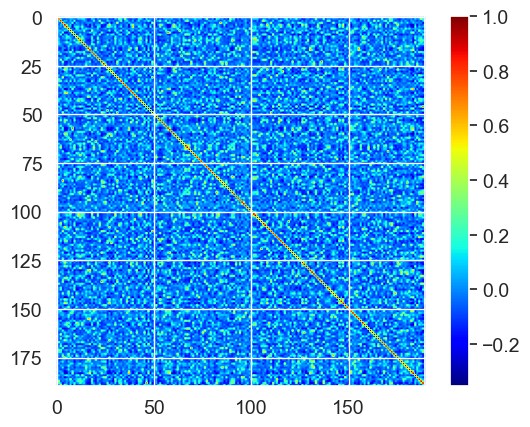

In [15]:
plt.imshow(A, cmap='jet')
plt.colorbar()
plt.show()

## K-NN for selecting edges

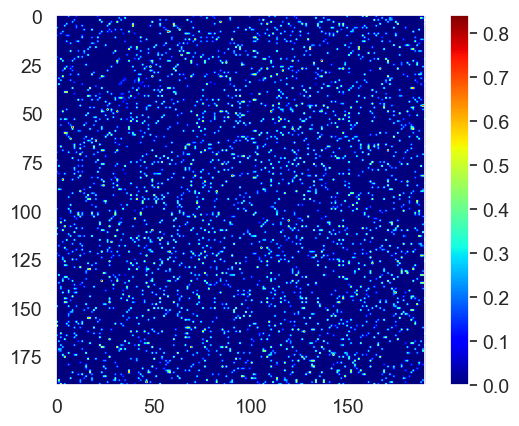

In [16]:
plt.imshow(np.array(ut.compute_KNN_graph(A, 15)),cmap='jet')
plt.colorbar()
plt.grid(False)
plt.show()

## Creating the graphs

In [17]:
train_data, val_data = ut.create_graph(pd.DataFrame(X_train),
                                    pd.DataFrame(X_test), pd.DataFrame(y_train), pd.DataFrame(y_test),
                                    method={'knn_group' : ut.compute_KNN_graph(A, 10)})# method={'knn' : 10}) #,method={'threshold': 0.2})

#train_data, TEST_data = create_graph(X_train, X_TEST, y_train, y_TEST, method={'knn_group' : compute_KNN_graph(A, 10)})# method={'knn' : 10}) #,method={'threshold': 0.2})

In [18]:
print(train_data[-1])

Data(x=[190, 190], edge_index=[2, 2218], edge_attr=[2218, 1], y=1)


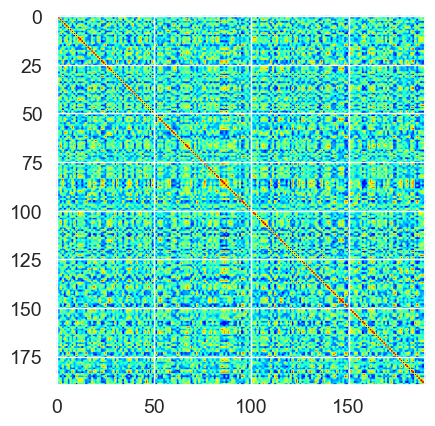

In [19]:
plt.imshow(train_data[-1].x,cmap='jet')

In [20]:
train_loader, val_loader = ut.create_batch(train_data, val_data, batch_size=32)

#TRAIN_loader, TEST_loader = create_batch(train_data, TEST_data, batch_size=20)

In [21]:
print('Validation balance \n 0 = {:.2f}% \n'.format(y_test.value_counts()[0]/len(y_test)), '1 = {:.2f}%'.format(y_test.value_counts()[1]/len(y_test)))
print('----------------------')
#print('TEST balance \n 0 = {:.2f}% \n'.format(y_TEST.value_counts()[0]/len(y_TEST)), '1 = {:.2f}%'.format(y_TEST.value_counts()[1]/len(y_TEST)))

Validation balance 
 0 = 0.33% 
 1 = 0.67%
----------------------


In [26]:
import torch
import torch.nn as nn
import torch.nn.functional as func
from torch_geometric.nn import ChebConv, GCNConv, global_mean_pool, GATv2Conv, global_max_pool


class GCN(torch.nn.Module):
    """GCN model(network architecture can be modified)"""

    def __init__(self,
                 num_features,
                 num_classes,
                 k_order,
                 dropout=.6):
        super(GCN, self).__init__()

        self.p = dropout
        
        #self.conv1 = GCNConv(int(num_features), 148)
        #self.conv2 = GCNConv(148,100)
        #self.conv3 = GCNConv(64,32)
        
        #self.gat1 = GATv2Conv(int(num_features),128, heads=4, edge_dim=1)
        #self.gat2 = GATv2Conv(128*4, 64, heads=1)
        #self.gat3 = GATv2Conv(128*2, 148, heads=1)
        
        self.conv1 = ChebConv(int(num_features), 64, K=k_order)
        self.conv2 = ChebConv(64,32, K=k_order)
        #self.conv3 = ChebConv(128, 80, K=k_order)

        self.lin1 = torch.nn.Linear(32, 2)
        #self.lin2 = torch.nn.Linear(4, int(num_classes))
        
        #torch.nn.init.xavier_normal_(self.gat1)
        #torch.nn.init.xavier_normal_(self.gat2)
        torch.nn.init.xavier_normal_(self.lin1.weight)


#         self.bn1 = torch.nn.BatchNorm1d(2)
#         self.bn2 = torch.nn.BatchNorm1d(72)
#         self.bn3 = torch.nn.BatchNorm1d(36)
        
        self.pool = global_mean_pool

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        batch = data.batch

        x = torch.relu(self.conv1(x, edge_index, edge_attr)) #WHY NAN WITH EDGE_ATTR (non-negative)
        #print('1', x.shape)
        #x,(index,att) = self.gat1(x=x, edge_index = edge_index,edge_attr=edge_attr,return_attention_weights=True)
        #x = func.elu(x)
        #print(att.shape)
        x = func.dropout(x, p=self.p, training=self.training)
        #x = self.bn1(x)
        x = torch.relu(self.conv2(x, edge_index, edge_attr))  #WHY NAN WITH EDGE_ATTR (non-negative)
        #print('2', x.shape)
        #x = self.gat2(x, edge_index)
        #x = func.elu(x)
        #x = func.dropout(x, p=self.p, training=self.training)
        #x = torch.tanh(self.conv3(x, edge_index, edge_attr))

        #print(x.shape)
        x = self.pool(x, batch)
        #x = x.reshape(len(batch.unique()),190,190).mean(axis=2)
        #print(x.shape)
        #print('pool', x.shape)
        #print(batch.shape)
        #x = func.log_softmax(x, dim=1)
        x = self.lin1(x)
        #print('lin', x.shape)
        #print(x.shape)
        return x, (1,2)#(index,att)

In [27]:
model = GCN(190,2,3)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

42786

# Testing in one fold

In [30]:
def TRAIN_LOSS(loader):
    model.eval()
    l1_weight = 1e-3
    
    pred = []
    label = []
    
    loss_all = 0
    for data in loader:
        data = data.to(device)
        output = model(data)[0]
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss = func.cross_entropy(output, data.y)
        loss_with_penalty = loss + l1_penalty
        loss_all += data.num_graphs * loss_with_penalty.item()
        pred.append(func.softmax(output, dim=1).max(dim=1)[1])
        label.append(data.y)

    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    tn, fp, fn, tp = confusion_matrix(y_pred, y_true).ravel()
    epoch_acc = (tn + tp) / (tn + tp + fn + fp)
    
    # AUC & ROC
    # fpr, tpr, _ = roc_curve(y_true, y_pred)
    # roc_auc = auc(fpr, tpr)
    
    return epoch_acc, loss_all / len(train_data)

def GCN_train(loader, loop):
    model.train()
    l1_weight = 1e-3
    loss_all = 0
    pred = []
    label = []
    
        
    for (x, y) in enumerate(loop):
        y = y.to(device)
        optimizer.zero_grad()
        output = model(y)[0]
        #print(output)
        # Adding L1 regularization
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss = func.cross_entropy(output, y.y)
        loss_with_penalty = loss + l1_penalty
        loss_with_penalty.backward()
        optimizer.step()
        loss_all += y.num_graphs * loss_with_penalty.item()
        pred.append(func.softmax(output, dim=1).max(dim=1)[1])
        label.append(y.y)

        loop.set_description(f"Epoch [{epoch}/{NUM_EPOCHS}]")
        loop.set_postfix(loss=loss_all/len(train_data))
        #optimizer.step()
    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    tn, fp, fn, tp = confusion_matrix(y_pred, y_true).ravel()
    epoch_acc = (tn + tp) / (tn + tp + fn + fp)
        
    return epoch_acc, loss_all / len(train_data)


def GCN_test(loader):
    
    model.eval()
    l1_weight = 1e-3
    
    pred = []
    label = []
    
    loss_all = 0
    for data in loader:
        data = data.to(device)
        output = model(data)[0]
        l1_penalty = l1_weight * sum([p.abs().sum() for p in model.parameters()])
        loss = func.cross_entropy(output, data.y)
        loss_with_penalty = loss + l1_penalty
        loss_all += data.num_graphs * loss_with_penalty.item()
        pred.append(func.softmax(output, dim=1).max(dim=1)[1])
        label.append(data.y)

    y_pred = torch.cat(pred, dim=0).cpu().detach().numpy()
    y_true = torch.cat(label, dim=0).cpu().detach().numpy()
    tn, fp, fn, tp = confusion_matrix(y_pred, y_true).ravel()
    epoch_rec = tp / (tp + fn)
    epoch_prec = tp / (tp + fp)
    epoch_f1 = 2*(epoch_rec*epoch_prec)/(epoch_rec + epoch_prec)
    epoch_acc = (tn + tp) / (tn + tp + fn + fp)
    
    # AUC & ROC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    
    return epoch_rec, epoch_prec, epoch_acc, loss_all / len(val_data), roc_auc,epoch_f1


In [31]:
metrics = {"loss_train" : [], "loss_test" : [], "acc_test" : [], "acc_train" : []}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(190, 2, 5).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3 )#,momentum=0.35)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40], gamma=1, verbose=True)
   

min_v_loss = np.inf  

NUM_EPOCHS = 50

for epoch in range(1,NUM_EPOCHS + 1):
    loop = tqdm(train_loader)
    train_acc, train_loss = GCN_train(train_loader,loop)
    test_rec, test_prec, test_acc, test_loss, roc_auc, test_f1 = GCN_test(val_loader)
    TRAIN_acc, TRAIN_loss = TRAIN_LOSS(train_loader)
    
    scheduler.step()
    
    metrics['loss_train'].append(TRAIN_loss)
    metrics['loss_test'].append(test_loss)
    metrics['acc_test'].append(test_acc)
    metrics['acc_train'].append(TRAIN_acc)
    
    print('Val Accuracy {} , Val Loss {}'.format(test_acc, test_loss))
    print('Train Accuracy {} , Train Loss {}'.format(TRAIN_acc, TRAIN_loss))

#     y_pred = {'x1' : [], 'x2' : [], 'label' : []}
#     for y in val_loader:
#         y_pred['x1'].append(model(y).detach().numpy()[0][0])
#         y_pred['x2'].append(model(y).detach().numpy()[0][1])
#         y_pred['label'].append(y.y.detach().numpy()[0])
        
#     sns.scatterplot(data=pd.DataFrame.from_dict(y_pred) , x='x1', y='x2', hue='label')
#     plt.show()
    

Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/50]: 100%|██████████████████| 57/57 [00:10<00:00,  5.28it/s, loss=5.26]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6314814814814815 , Val Loss 3.9274557639051366
Train Accuracy 0.6473509933774835 , Train Loss 3.9174909707463077


Epoch [2/50]: 100%|██████████████████| 57/57 [00:14<00:00,  4.02it/s, loss=2.98]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6777777777777778 , Val Loss 2.1677467622138837
Train Accuracy 0.6324503311258278 , Train Loss 2.1627828364340673


Epoch [3/50]: 100%|██████████████████| 57/57 [00:14<00:00,  3.82it/s, loss=1.67]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6648148148148149 , Val Loss 1.2708223660786946
Train Accuracy 0.6054083885209713 , Train Loss 1.2743822409880345


Epoch [4/50]: 100%|███████████████████| 57/57 [00:11<00:00,  5.15it/s, loss=1.1]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.957258094460876
Train Accuracy 0.5998896247240618 , Train Loss 0.9678988223833753


Epoch [5/50]: 100%|███████████████████| 57/57 [00:11<00:00,  5.04it/s, loss=0.9]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.8235259556108051
Train Accuracy 0.5982339955849889 , Train Loss 0.8366927636117072


Epoch [6/50]: 100%|█████████████████| 57/57 [00:11<00:00,  4.96it/s, loss=0.802]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.7539239390028848
Train Accuracy 0.5982339955849889 , Train Loss 0.7696794251732478


Epoch [7/50]: 100%|█████████████████| 57/57 [00:11<00:00,  4.86it/s, loss=0.754]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.7215068697929382
Train Accuracy 0.5982339955849889 , Train Loss 0.737490246759082


Epoch [8/50]: 100%|█████████████████| 57/57 [00:11<00:00,  4.77it/s, loss=0.728]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.7023475614962754
Train Accuracy 0.5982339955849889 , Train Loss 0.719201766497252


Epoch [9/50]: 100%|█████████████████| 57/57 [00:14<00:00,  3.91it/s, loss=0.714]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.6895273686559112
Train Accuracy 0.5982339955849889 , Train Loss 0.7077909971178236


Epoch [10/50]: 100%|████████████████| 57/57 [00:16<00:00,  3.38it/s, loss=0.704]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.6818183605317716
Train Accuracy 0.5982339955849889 , Train Loss 0.7008054606435578


Epoch [11/50]: 100%|████████████████| 57/57 [00:10<00:00,  5.43it/s, loss=0.699]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.6762173929700145
Train Accuracy 0.5982339955849889 , Train Loss 0.6963712724365673


Epoch [12/50]: 100%|████████████████| 57/57 [00:11<00:00,  5.04it/s, loss=0.695]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.6729951820991658
Train Accuracy 0.5982339955849889 , Train Loss 0.6935652265485549


Epoch [13/50]: 100%|████████████████| 57/57 [00:11<00:00,  5.14it/s, loss=0.693]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.6704111582703061
Train Accuracy 0.5982339955849889 , Train Loss 0.6916525154713763


Epoch [14/50]: 100%|████████████████| 57/57 [00:11<00:00,  4.97it/s, loss=0.691]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.6681644142777832
Train Accuracy 0.5982339955849889 , Train Loss 0.6900739754009457


Epoch [15/50]: 100%|█████████████████| 57/57 [00:11<00:00,  4.80it/s, loss=0.69]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.6666625625005475
Train Accuracy 0.5982339955849889 , Train Loss 0.688931497517011


Epoch [16/50]: 100%|████████████████| 57/57 [00:11<00:00,  4.85it/s, loss=0.689]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.6656756588154369
Train Accuracy 0.5982339955849889 , Train Loss 0.6884006698663134


Epoch [17/50]: 100%|████████████████| 57/57 [00:11<00:00,  5.10it/s, loss=0.688]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.6642666255986249
Train Accuracy 0.5982339955849889 , Train Loss 0.6875883050049114


Epoch [18/50]: 100%|████████████████| 57/57 [00:11<00:00,  4.91it/s, loss=0.687]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.6634473820527395
Train Accuracy 0.5982339955849889 , Train Loss 0.6870350835075968


Epoch [19/50]: 100%|████████████████| 57/57 [00:12<00:00,  4.74it/s, loss=0.687]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.6626744384015048
Train Accuracy 0.5982339955849889 , Train Loss 0.6866223446317593


Epoch [20/50]: 100%|████████████████| 57/57 [00:13<00:00,  4.16it/s, loss=0.687]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.6620248245972175
Train Accuracy 0.5982339955849889 , Train Loss 0.6863178084491368


Epoch [21/50]: 100%|████████████████| 57/57 [00:11<00:00,  4.82it/s, loss=0.686]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.6613203545411428
Train Accuracy 0.5982339955849889 , Train Loss 0.6860263537097451


Epoch [22/50]: 100%|████████████████| 57/57 [00:11<00:00,  4.97it/s, loss=0.686]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.6607821468953733
Train Accuracy 0.5982339955849889 , Train Loss 0.6857159782455984


Epoch [23/50]: 100%|████████████████| 57/57 [00:11<00:00,  5.04it/s, loss=0.686]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.6599354573973903
Train Accuracy 0.5982339955849889 , Train Loss 0.6852835627317955


Epoch [24/50]: 100%|████████████████| 57/57 [00:11<00:00,  4.87it/s, loss=0.685]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.6591240348639311
Train Accuracy 0.5982339955849889 , Train Loss 0.6848285482419247


Epoch [25/50]: 100%|████████████████| 57/57 [00:12<00:00,  4.72it/s, loss=0.685]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.6584995685904115
Train Accuracy 0.5982339955849889 , Train Loss 0.6845040354244494


Epoch [26/50]: 100%|████████████████| 57/57 [00:11<00:00,  5.09it/s, loss=0.684]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.6579534295532439
Train Accuracy 0.5982339955849889 , Train Loss 0.6841352899079818


Epoch [27/50]: 100%|████████████████| 57/57 [00:10<00:00,  5.22it/s, loss=0.684]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.6573605229457219
Train Accuracy 0.5982339955849889 , Train Loss 0.6837838859221267


Epoch [28/50]: 100%|████████████████| 57/57 [00:12<00:00,  4.75it/s, loss=0.684]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.6569073505975582
Train Accuracy 0.5982339955849889 , Train Loss 0.6834928278891456


Epoch [29/50]: 100%|████████████████| 57/57 [00:11<00:00,  5.16it/s, loss=0.683]


Adjusting learning rate of group 0 to 1.0000e-03.
Val Accuracy 0.6703703703703704 , Val Loss 0.6566031166800746
Train Accuracy 0.5982339955849889 , Train Loss 0.6832399949859046


Epoch [30/50]:  91%|██████████████▌ | 52/57 [00:11<00:01,  4.49it/s, loss=0.628]


KeyboardInterrupt: 


### Debug

In [57]:
model.eval()

GCN(
  (conv1): ChebConv(190, 128, K=5, normalization=sym)
  (lin1): Linear(in_features=128, out_features=2, bias=True)
)

In [69]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name)
#         print(param.data.shape)
#         if name=='gat1.att': 
#             gat1 = param.data
#             #print(name, param.data)

In [70]:
# gat1.shape

In [71]:
# plt.imshow(gat1[0,:,:])

In [61]:
# y_pred = []
# for y_i in TEST_loader:
#     #print(model(y).detach().numpy()[0][0])
#     #y_pred.append(model(y).detach().numpy())
#     y_pred.append(np.array(func.softmax(model(y_i), dim=1).detach().max(dim=1)[1]))
    
# print('TEST accuracy', accuracy_score(y_TEST.values.reshape(-1,1), y_pred))


In [62]:
y_pred = []
for y_i in val_loader:
    #y_pred.append(model(y).detach().numpy())
    y_pred.append(func.softmax(model(y_i)[0], dim=1).detach().numpy())#.max(dim=1)[1])
index, gat = model(y_i)[1]

In [64]:
# gat[100,3].detach().numpy()

In [65]:
# gat_matrix = np.zeros((190,190))
# cont = 0
# for i, row in pd.DataFrame(index).T.iterrows():
#     gat_matrix[int(row.values[0]), int(row.values[1])] = gat[cont,0].detach().numpy()
#     cont += 1

In [66]:
# plt.hist(gat_matrix.ravel())

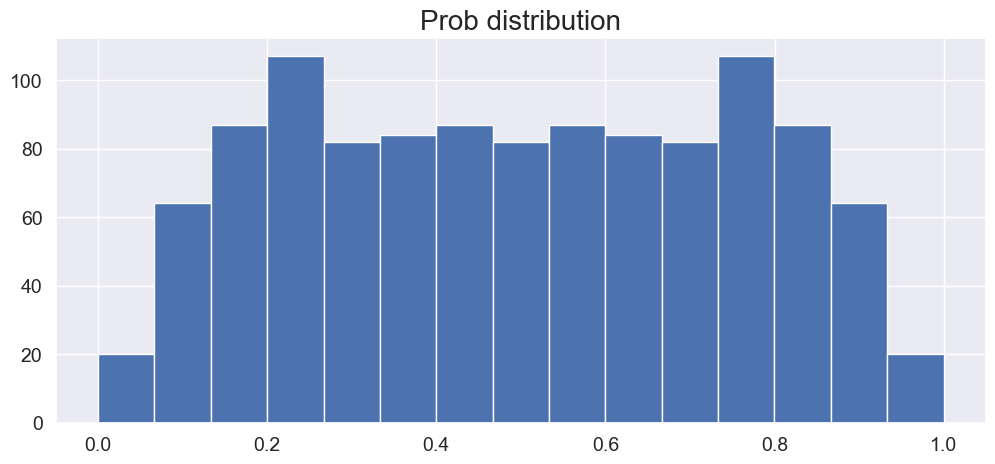

In [67]:
plt.figure(figsize=(12,5))
plt.hist(np.array(y_pred).reshape(len(y_pred)*2), bins=15)
plt.title("Prob distribution")
plt.show()

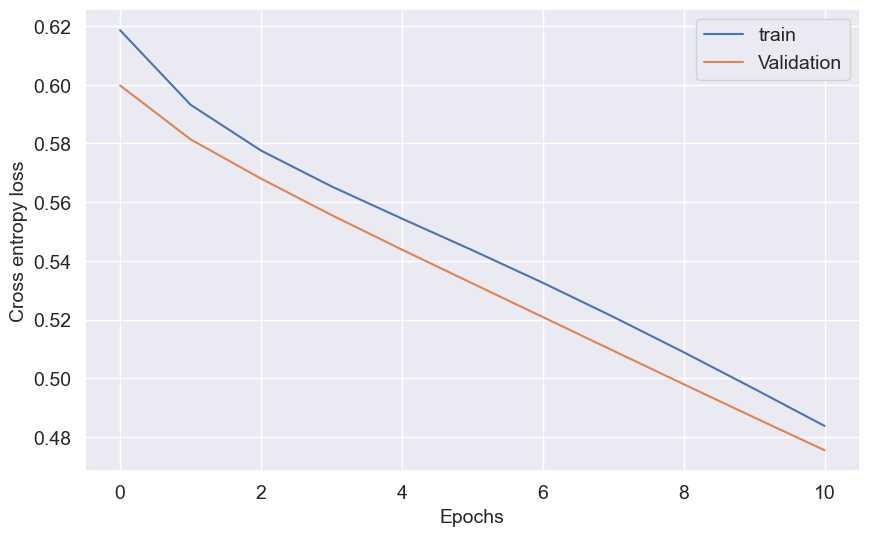

In [68]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(metrics['loss_train'], label='train')
ax.plot(metrics['loss_test'], label='Validation')
ax.set_ylabel('Cross entropy loss')
ax.set_xlabel('Epochs')
ax.legend()
#plt.xlim(0,100)
plt.show()

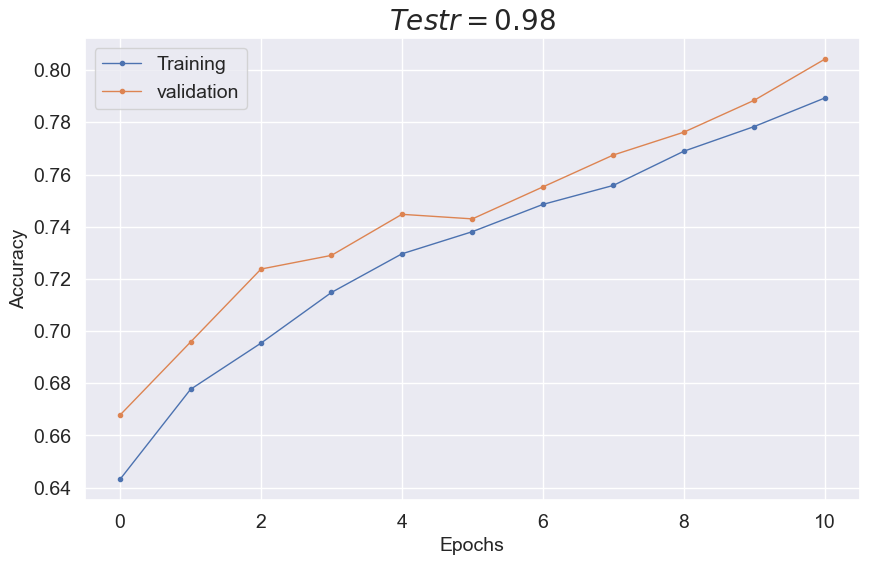

In [72]:
fig,ax = plt.subplots(figsize=(10,6))
ax.plot(metrics['acc_train'], label='Training', linewidth=1,marker='.')
ax.plot(metrics['acc_test'], label='validation', linewidth=1,marker='.')
ax.set_ylabel('Accuracy')
ax.set_xlabel('Epochs')
ax.set_title(r'$Test r = {:.2f}$'.format(np.corrcoef(np.arange(0,len(metrics['acc_test'])), metrics['acc_test'])[0][1]))
ax.legend()
plt.show()

In [73]:
X_train

array([[-0.26748853, -0.02437265,  0.28478753, ...,  0.05036029,
        -0.16346826,  0.26487845],
       [-0.03774038, -0.02823228, -0.03259386, ...,  0.58854467,
        -0.07047067, -0.18177955],
       [-0.00076698,  0.22270389, -0.16854481, ...,  0.47197914,
        -0.25399374,  0.21721193],
       ...,
       [-0.38895331, -0.04380904, -0.03271651, ...,  0.4765449 ,
        -0.1073977 ,  0.01220105],
       [-0.38232611,  0.22685963, -0.0220608 , ...,  0.33583129,
        -0.7100464 ,  0.10239143],
       [ 0.44550565, -0.3243568 ,  0.53296088, ...,  0.0958766 ,
        -0.11200184, -0.00546685]])

## Kfold Cross validation

In [26]:
X_train, y_train, X_test, y_test = ut.cross_val_data(df, folds=5, site=True)

/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/GCN_study/lib/python3.9/

In [50]:
from sklearn.preprocessing import StandardScaler

eval_scores = {"loss_train" : [], "loss_test" : [], "acc_test" : [], "acc_train" : []}

scores = np.zeros((6,5))

# K-fold Cross Validation model evaluation
fold_no = 1
for k in range(3):
    
#     scaler = StandardScaler()
#     X_train[k] = scaler.fit_transform(X_train[k])
    
# #     scaler = StandardScaler()
#     X_test[k] = scaler.transform(X_test[k])
    
    group_fc  = X_train[k].mean(axis=0)
    
    # creating the graphs
    train_data, val_data = ut.create_graph(pd.DataFrame(X_train[k]),
                                    pd.DataFrame(X_test[k]), pd.DataFrame(y_train[k].values),
                                        pd.DataFrame(y_test[k].values),
                                    method={'knn_group' : ut.compute_KNN_graph(ut.reconstruct_symmetric_matrix(190,group_fc), 15)})    
    # creating the batchs inside the torch DataLoader
    
    train_loader, val_loader = ut.create_batch(train_data, val_data, batch_size=32)
    

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    print(' 0 = {:.2f}% \n'.format(y_test[k].value_counts()[0]/len(y_test[k])),
          '1 = {:.2f}%'.format(y_test[k].value_counts()[1]/len(y_test[k])))


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = GCN(190, 2, 3).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)#,momentum=0.35)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40], gamma=1, verbose=True)

    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()


    min_v_loss = np.inf  


    NUM_EPOCHS = 40
    for epoch in range(1,NUM_EPOCHS + 1):
        loop = tqdm(train_loader)
        train_acc, train_loss = GCN_train(train_loader,loop)
        test_rec, test_prec, test_acc, test_loss, roc_auc, test_f1  = GCN_test(val_loader)
        TRAIN_acc, TRAIN_loss = TRAIN_LOSS(train_loader)
        
        #if test_loss_hist < test_loss and test_loss_hist != 0:
        #    break
        #test_loss_hist = test_loss
    

        eval_scores['loss_train'].append(TRAIN_loss)
        eval_scores['loss_test'].append(test_loss)
        eval_scores['acc_test'].append(test_acc)
        eval_scores['acc_train'].append(TRAIN_acc)
        
        print('Val Accuracy {} , Val Loss {}'.format(test_acc, test_loss))
        print('Train Accuracy {} , Train Loss {}'.format(TRAIN_acc, TRAIN_loss))

    
    scores[0][fold_no - 1] = test_acc
    scores[1][fold_no - 1] = test_rec
    scores[2][fold_no - 1] = test_prec
    scores[3][fold_no - 1] = test_loss
    scores[4][fold_no - 1] = roc_auc
    scores[5][fold_no - 1] = test_f1

    print(f'Score for fold {fold_no}: loss of {test_loss}; acc of {test_acc}%; AUC of {roc_auc}%')

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
 0 = 0.41% 
 1 = 0.59%
Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/40]: 100%|█████████████████| 55/55 [00:06<00:00,  7.92it/s, loss=0.885]


Val Accuracy 0.5939597315436241 , Val Loss 0.8570479172588195
Train Accuracy 0.6224373576309795 , Train Loss 0.8410817276100906


Epoch [2/40]: 100%|█████████████████| 55/55 [00:07<00:00,  7.86it/s, loss=0.814]


Val Accuracy 0.587248322147651 , Val Loss 0.800949052376235
Train Accuracy 0.6383826879271071 , Train Loss 0.7826805228795983


Epoch [3/40]: 100%|██████████████████| 55/55 [00:06<00:00,  7.88it/s, loss=0.76]


Val Accuracy 0.5989932885906041 , Val Loss 0.7618224339797193
Train Accuracy 0.657744874715262 , Train Loss 0.7319261025730732


Epoch [4/40]: 100%|█████████████████| 55/55 [00:06<00:00,  7.97it/s, loss=0.721]


Val Accuracy 0.5973154362416108 , Val Loss 0.7407337028108187
Train Accuracy 0.6674259681093394 , Train Loss 0.6944975233838335


Epoch [5/40]: 100%|█████████████████| 55/55 [00:07<00:00,  7.39it/s, loss=0.692]


Val Accuracy 0.5973154362416108 , Val Loss 0.7309440776405719
Train Accuracy 0.6771070615034168 , Train Loss 0.6676055897612778


Epoch [6/40]: 100%|█████████████████| 55/55 [00:07<00:00,  7.49it/s, loss=0.668]


Val Accuracy 0.6057046979865772 , Val Loss 0.7219213502319067
Train Accuracy 0.6947608200455581 , Train Loss 0.6476048607217967


Epoch [7/40]: 100%|█████████████████| 55/55 [00:07<00:00,  7.71it/s, loss=0.653]


Val Accuracy 0.6090604026845637 , Val Loss 0.7179032664171001
Train Accuracy 0.6981776765375854 , Train Loss 0.6307703449405679


Epoch [8/40]: 100%|█████████████████| 55/55 [00:07<00:00,  7.65it/s, loss=0.637]


Val Accuracy 0.6140939597315436 , Val Loss 0.7170782887545608
Train Accuracy 0.7084282460136674 , Train Loss 0.6162995835914699


Epoch [9/40]: 100%|█████████████████| 55/55 [00:07<00:00,  7.72it/s, loss=0.625]


Val Accuracy 0.6124161073825504 , Val Loss 0.7165264648904136
Train Accuracy 0.7146924829157175 , Train Loss 0.6059242288724165


Epoch [10/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.62it/s, loss=0.616]


Val Accuracy 0.6157718120805369 , Val Loss 0.7179636090693858
Train Accuracy 0.7232346241457859 , Train Loss 0.5965404871656032


Epoch [11/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.69it/s, loss=0.605]


Val Accuracy 0.6174496644295302 , Val Loss 0.7176792997266822
Train Accuracy 0.729498861047836 , Train Loss 0.5871796242739997


Epoch [12/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.80it/s, loss=0.598]


Val Accuracy 0.6241610738255033 , Val Loss 0.7186553776389201
Train Accuracy 0.7374715261958997 , Train Loss 0.5792357984056233


Epoch [13/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.77it/s, loss=0.596]


Val Accuracy 0.6325503355704698 , Val Loss 0.7187466911171507
Train Accuracy 0.7369020501138952 , Train Loss 0.5721466105456776


Epoch [14/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.75it/s, loss=0.586]


Val Accuracy 0.6291946308724832 , Val Loss 0.7175659368677227
Train Accuracy 0.7414578587699316 , Train Loss 0.565071975044346


Epoch [15/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.73it/s, loss=0.581]


Val Accuracy 0.6375838926174496 , Val Loss 0.7182985773847607
Train Accuracy 0.7539863325740319 , Train Loss 0.5559619441119305


Epoch [16/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.63it/s, loss=0.576]


Val Accuracy 0.6308724832214765 , Val Loss 0.7250998050799505
Train Accuracy 0.755125284738041 , Train Loss 0.5517041702205336


Epoch [17/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.71it/s, loss=0.572]


Val Accuracy 0.6526845637583892 , Val Loss 0.7213127927217108
Train Accuracy 0.7596810933940774 , Train Loss 0.5446438042612445


Epoch [18/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.65it/s, loss=0.559]


Val Accuracy 0.639261744966443 , Val Loss 0.7254779028624996
Train Accuracy 0.7648063781321185 , Train Loss 0.5402802383709605


Epoch [19/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.70it/s, loss=0.564]


Val Accuracy 0.6409395973154363 , Val Loss 0.7206100161756145
Train Accuracy 0.7750569476082004 , Train Loss 0.533352301848505


Epoch [20/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.63it/s, loss=0.567]


Val Accuracy 0.6342281879194631 , Val Loss 0.7301224479014241
Train Accuracy 0.7659453302961275 , Train Loss 0.5320470124007901


Epoch [21/40]: 100%|████████████████| 55/55 [00:06<00:00,  8.09it/s, loss=0.545]


Val Accuracy 0.6543624161073825 , Val Loss 0.7194985291176794
Train Accuracy 0.7796127562642369 , Train Loss 0.5220354287662375


Epoch [22/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.73it/s, loss=0.556]


Val Accuracy 0.6543624161073825 , Val Loss 0.7205058032796787
Train Accuracy 0.7824601366742597 , Train Loss 0.5166959721841139


Epoch [23/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.47it/s, loss=0.546]


Val Accuracy 0.6610738255033557 , Val Loss 0.7194021194423205
Train Accuracy 0.7938496583143508 , Train Loss 0.5113225788353244


Epoch [24/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.72it/s, loss=0.535]


Val Accuracy 0.6526845637583892 , Val Loss 0.7219029645429261
Train Accuracy 0.7955580865603644 , Train Loss 0.5011811866032507


Epoch [25/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.64it/s, loss=0.527]


Val Accuracy 0.6442953020134228 , Val Loss 0.7308092268321338
Train Accuracy 0.7944191343963554 , Train Loss 0.5000590296432478


Epoch [26/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.59it/s, loss=0.526]


Val Accuracy 0.6526845637583892 , Val Loss 0.724582786846831
Train Accuracy 0.7961275626423691 , Train Loss 0.49349546744774575


Epoch [27/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.65it/s, loss=0.534]


Val Accuracy 0.6577181208053692 , Val Loss 0.7218449664920968
Train Accuracy 0.8046697038724373 , Train Loss 0.4857657428890263


Epoch [28/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.61it/s, loss=0.522]


Val Accuracy 0.6644295302013423 , Val Loss 0.7189527608441727
Train Accuracy 0.8086560364464692 , Train Loss 0.4835008165559356


Epoch [29/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.70it/s, loss=0.515]


Val Accuracy 0.6593959731543624 , Val Loss 0.7266897864502249
Train Accuracy 0.8120728929384966 , Train Loss 0.4756682334565356


Epoch [30/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.54it/s, loss=0.531]


Val Accuracy 0.6694630872483222 , Val Loss 0.7262571224655281
Train Accuracy 0.8189066059225513 , Train Loss 0.47118895960831697


Epoch [31/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.78it/s, loss=0.509]


Val Accuracy 0.6526845637583892 , Val Loss 0.7269341989589118
Train Accuracy 0.8194760820045558 , Train Loss 0.4641144291958125


Epoch [32/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.70it/s, loss=0.502]


Val Accuracy 0.6610738255033557 , Val Loss 0.7248177966790511
Train Accuracy 0.8251708428246014 , Train Loss 0.4598627498454005


Epoch [33/40]: 100%|██████████████████| 55/55 [00:07<00:00,  7.75it/s, loss=0.5]


Val Accuracy 0.6560402684563759 , Val Loss 0.7268815557128631
Train Accuracy 0.8297266514806378 , Train Loss 0.4560838689293568


Epoch [34/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.20it/s, loss=0.505]


Val Accuracy 0.6593959731543624 , Val Loss 0.7157501545328422
Train Accuracy 0.8285876993166287 , Train Loss 0.4501756876367643


Epoch [35/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.80it/s, loss=0.498]


Val Accuracy 0.6493288590604027 , Val Loss 0.7311743751243257
Train Accuracy 0.8280182232346242 , Train Loss 0.4499663893888643


Epoch [36/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.81it/s, loss=0.485]


Val Accuracy 0.6577181208053692 , Val Loss 0.7225882861600726
Train Accuracy 0.8342824601366743 , Train Loss 0.4383118777856197


Epoch [37/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.72it/s, loss=0.493]


Val Accuracy 0.6510067114093959 , Val Loss 0.724833255533704
Train Accuracy 0.8388382687927107 , Train Loss 0.4395729399759297


Epoch [38/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.79it/s, loss=0.495]


Val Accuracy 0.6560402684563759 , Val Loss 0.7266235428756015
Train Accuracy 0.8399772209567198 , Train Loss 0.43222324024028824


Epoch [39/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.76it/s, loss=0.482]


Val Accuracy 0.6661073825503355 , Val Loss 0.7191076330378051
Train Accuracy 0.8394077448747153 , Train Loss 0.42817780776013004


Epoch [40/40]: 100%|████████████████| 55/55 [00:07<00:00,  7.75it/s, loss=0.481]


Val Accuracy 0.6526845637583892 , Val Loss 0.7201578293945765
Train Accuracy 0.8433940774487472 , Train Loss 0.4248489325437568
Score for fold 1: loss of 0.7201578293945765; acc of 0.6526845637583892%; AUC of 0.6161110332913107%
------------------------------------------------------------------------
Training for fold 2 ...
 0 = 0.39% 
 1 = 0.61%
Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/40]: 100%|█████████████████| 58/58 [00:07<00:00,  7.83it/s, loss=0.888]


Val Accuracy 0.6141732283464567 , Val Loss 0.8536451823833421
Train Accuracy 0.6155097613882863 , Train Loss 0.8444754829117119


Epoch [2/40]: 100%|██████████████████| 58/58 [00:07<00:00,  7.71it/s, loss=0.82]


Val Accuracy 0.594488188976378 , Val Loss 0.8107075259441466
Train Accuracy 0.6290672451193059 , Train Loss 0.7841995688167415


Epoch [3/40]: 100%|█████████████████| 58/58 [00:07<00:00,  7.77it/s, loss=0.767]


Val Accuracy 0.6062992125984252 , Val Loss 0.7764681396991249
Train Accuracy 0.6491323210412148 , Train Loss 0.7334939374582369


Epoch [4/40]: 100%|█████████████████| 58/58 [00:07<00:00,  7.81it/s, loss=0.727]


Val Accuracy 0.6122047244094488 , Val Loss 0.7550170334188018
Train Accuracy 0.6572668112798264 , Train Loss 0.6972577185279119


Epoch [5/40]: 100%|█████████████████| 58/58 [00:07<00:00,  7.89it/s, loss=0.699]


Val Accuracy 0.6141732283464567 , Val Loss 0.7459937320567491
Train Accuracy 0.665943600867679 , Train Loss 0.6707755241890533


Epoch [6/40]: 100%|█████████████████| 58/58 [00:07<00:00,  7.79it/s, loss=0.673]


Val Accuracy 0.6043307086614174 , Val Loss 0.7484424702060504
Train Accuracy 0.6979392624728851 , Train Loss 0.6469186474599445


Epoch [7/40]: 100%|█████████████████| 58/58 [00:07<00:00,  7.99it/s, loss=0.658]


Val Accuracy 0.6082677165354331 , Val Loss 0.7477961950825425
Train Accuracy 0.7142082429501084 , Train Loss 0.6287946020962101


Epoch [8/40]: 100%|█████████████████| 58/58 [00:07<00:00,  7.90it/s, loss=0.644]


Val Accuracy 0.6122047244094488 , Val Loss 0.7510420703512477
Train Accuracy 0.7250542299349241 , Train Loss 0.6143228375472112


Epoch [9/40]: 100%|█████████████████| 58/58 [00:07<00:00,  7.91it/s, loss=0.632]


Val Accuracy 0.5984251968503937 , Val Loss 0.760672929264077
Train Accuracy 0.735357917570499 , Train Loss 0.6028043896670973


Epoch [10/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.79it/s, loss=0.624]


Val Accuracy 0.6023622047244095 , Val Loss 0.7620970207435174
Train Accuracy 0.7445770065075922 , Train Loss 0.5921628644564664


Epoch [11/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.95it/s, loss=0.615]


Val Accuracy 0.5964566929133859 , Val Loss 0.7629263106088234
Train Accuracy 0.7521691973969631 , Train Loss 0.5799318979981147


Epoch [12/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.97it/s, loss=0.606]


Val Accuracy 0.6141732283464567 , Val Loss 0.761022211925134
Train Accuracy 0.7608459869848156 , Train Loss 0.5720626798472539


Epoch [13/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.83it/s, loss=0.597]


Val Accuracy 0.6082677165354331 , Val Loss 0.767598635143065
Train Accuracy 0.764642082429501 , Train Loss 0.5633457194440018


Epoch [14/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.63it/s, loss=0.585]


Val Accuracy 0.6043307086614174 , Val Loss 0.7727919774584648
Train Accuracy 0.7651843817787418 , Train Loss 0.5548882565891406


Epoch [15/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.95it/s, loss=0.583]


Val Accuracy 0.6082677165354331 , Val Loss 0.7758654849677105
Train Accuracy 0.7744034707158352 , Train Loss 0.5485416509841373


Epoch [16/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.84it/s, loss=0.575]


Val Accuracy 0.6062992125984252 , Val Loss 0.7819830571983274
Train Accuracy 0.7803687635574837 , Train Loss 0.5381787180124809


Epoch [17/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.82it/s, loss=0.567]


Val Accuracy 0.6043307086614174 , Val Loss 0.7834014899471379
Train Accuracy 0.7819956616052061 , Train Loss 0.5294785313389048


Epoch [18/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.94it/s, loss=0.569]


Val Accuracy 0.5964566929133859 , Val Loss 0.7832055782796595
Train Accuracy 0.7819956616052061 , Train Loss 0.5243509852705188


Epoch [19/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.90it/s, loss=0.572]


Val Accuracy 0.6003937007874016 , Val Loss 0.7823347197478916
Train Accuracy 0.7852494577006508 , Train Loss 0.5224371405071913


Epoch [20/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.82it/s, loss=0.558]


Val Accuracy 0.6082677165354331 , Val Loss 0.7882434114461808
Train Accuracy 0.7906724511930586 , Train Loss 0.5146317056616578


Epoch [21/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.94it/s, loss=0.549]


Val Accuracy 0.6240157480314961 , Val Loss 0.7905740348519538
Train Accuracy 0.7912147505422994 , Train Loss 0.5102660684420075


Epoch [22/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.82it/s, loss=0.543]


Val Accuracy 0.6181102362204725 , Val Loss 0.790815168405025
Train Accuracy 0.7939262472885033 , Train Loss 0.5040374549505767


Epoch [23/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.87it/s, loss=0.549]


Val Accuracy 0.6122047244094488 , Val Loss 0.7932212987518686
Train Accuracy 0.7950108459869848 , Train Loss 0.5013864270518503


Epoch [24/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.83it/s, loss=0.547]


Val Accuracy 0.6122047244094488 , Val Loss 0.7946577171289076
Train Accuracy 0.7977223427331888 , Train Loss 0.49779857704799757


Epoch [25/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.75it/s, loss=0.538]


Val Accuracy 0.6200787401574803 , Val Loss 0.793557498010066
Train Accuracy 0.8101952277657267 , Train Loss 0.49076349176708894


Epoch [26/40]: 100%|████████████████| 58/58 [00:08<00:00,  7.07it/s, loss=0.536]


Val Accuracy 0.6279527559055118 , Val Loss 0.8007912258434249
Train Accuracy 0.8042299349240781 , Train Loss 0.4885812278942017


Epoch [27/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.50it/s, loss=0.531]


Val Accuracy 0.6161417322834646 , Val Loss 0.7977583790417966
Train Accuracy 0.8058568329718004 , Train Loss 0.4828419677606115


Epoch [28/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.77it/s, loss=0.529]


Val Accuracy 0.6181102362204725 , Val Loss 0.8041838445062712
Train Accuracy 0.8177874186550976 , Train Loss 0.47876480745390027


Epoch [29/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.92it/s, loss=0.525]


Val Accuracy 0.6200787401574803 , Val Loss 0.8080144494654625
Train Accuracy 0.8101952277657267 , Train Loss 0.4762654582487011


Epoch [30/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.88it/s, loss=0.531]


Val Accuracy 0.6181102362204725 , Val Loss 0.8092284283094754
Train Accuracy 0.8129067245119306 , Train Loss 0.47476470948817157


Epoch [31/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.84it/s, loss=0.512]


Val Accuracy 0.6141732283464567 , Val Loss 0.8121442893431998
Train Accuracy 0.8264642082429501 , Train Loss 0.4664676877267966


Epoch [32/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.80it/s, loss=0.513]


Val Accuracy 0.6279527559055118 , Val Loss 0.8110606891770414
Train Accuracy 0.8188720173535792 , Train Loss 0.4635056908890896


Epoch [33/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.85it/s, loss=0.502]


Val Accuracy 0.6240157480314961 , Val Loss 0.8198450713851085
Train Accuracy 0.8264642082429501 , Train Loss 0.4552461713099945


Epoch [34/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.78it/s, loss=0.506]


Val Accuracy 0.6181102362204725 , Val Loss 0.8199651475966446
Train Accuracy 0.8373101952277657 , Train Loss 0.4521495045653651


Epoch [35/40]: 100%|████████████████| 58/58 [00:08<00:00,  7.11it/s, loss=0.508]


Val Accuracy 0.6161417322834646 , Val Loss 0.8186439329054295
Train Accuracy 0.8248373101952278 , Train Loss 0.45115793850313296


Epoch [36/40]: 100%|████████████████| 58/58 [00:11<00:00,  5.23it/s, loss=0.512]


Val Accuracy 0.6259842519685039 , Val Loss 0.813297020462085
Train Accuracy 0.8280911062906724 , Train Loss 0.45186304309104375


Epoch [37/40]: 100%|████████████████| 58/58 [00:10<00:00,  5.30it/s, loss=0.507]


Val Accuracy 0.6200787401574803 , Val Loss 0.8245452835525232
Train Accuracy 0.8232104121475055 , Train Loss 0.44787038794825756


Epoch [38/40]: 100%|████████████████| 58/58 [00:10<00:00,  5.34it/s, loss=0.512]


Val Accuracy 0.6299212598425197 , Val Loss 0.8209669002676456
Train Accuracy 0.824295010845987 , Train Loss 0.4475371819514773


Epoch [39/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.81it/s, loss=0.491]


Val Accuracy 0.6141732283464567 , Val Loss 0.8316236298941956
Train Accuracy 0.8308026030368764 , Train Loss 0.44070045640308275


Epoch [40/40]: 100%|████████████████| 58/58 [00:07<00:00,  8.14it/s, loss=0.492]


Val Accuracy 0.6259842519685039 , Val Loss 0.8347546112994979
Train Accuracy 0.8356832971800434 , Train Loss 0.43515322420447095
Score for fold 2: loss of 0.8347546112994979; acc of 0.6259842519685039%; AUC of 0.5779042386185242%
------------------------------------------------------------------------
Training for fold 3 ...
 0 = 0.36% 
 1 = 0.64%
Adjusting learning rate of group 0 to 1.0000e-03.


Epoch [1/40]: 100%|█████████████████| 58/58 [00:07<00:00,  8.20it/s, loss=0.882]


Val Accuracy 0.644 , Val Loss 0.8328248682022095
Train Accuracy 0.6063714902807775 , Train Loss 0.8361056103304705


Epoch [2/40]: 100%|█████████████████| 58/58 [00:08<00:00,  7.17it/s, loss=0.807]


Val Accuracy 0.634 , Val Loss 0.7832278814315796
Train Accuracy 0.6166306695464363 , Train Loss 0.7762904292048954


Epoch [3/40]: 100%|█████████████████| 58/58 [00:06<00:00,  8.44it/s, loss=0.756]


Val Accuracy 0.598 , Val Loss 0.7543832010030747
Train Accuracy 0.6398488120950324 , Train Loss 0.7350176966731028


Epoch [4/40]: 100%|█████████████████| 58/58 [00:07<00:00,  7.62it/s, loss=0.722]


Val Accuracy 0.6 , Val Loss 0.7354162526726723
Train Accuracy 0.6528077753779697 , Train Loss 0.7034413674222728


Epoch [5/40]: 100%|███████████████████| 58/58 [00:07<00:00,  8.28it/s, loss=0.7]


Val Accuracy 0.586 , Val Loss 0.7268308320045471
Train Accuracy 0.6744060475161987 , Train Loss 0.6827755879377443


Epoch [6/40]: 100%|█████████████████| 58/58 [00:06<00:00,  8.42it/s, loss=0.684]


Val Accuracy 0.586 , Val Loss 0.7219514791965485
Train Accuracy 0.6830453563714903 , Train Loss 0.6656936090399328


Epoch [7/40]: 100%|█████████████████| 58/58 [00:07<00:00,  8.01it/s, loss=0.672]


Val Accuracy 0.6 , Val Loss 0.7162596119344234
Train Accuracy 0.6868250539956804 , Train Loss 0.6505252251614763


Epoch [8/40]: 100%|█████████████████| 58/58 [00:06<00:00,  8.39it/s, loss=0.658]


Val Accuracy 0.6 , Val Loss 0.7115033523738384
Train Accuracy 0.6922246220302376 , Train Loss 0.6369231891683574


Epoch [9/40]: 100%|█████████████████| 58/58 [00:07<00:00,  8.08it/s, loss=0.648]


Val Accuracy 0.6 , Val Loss 0.7102149795293808
Train Accuracy 0.6997840172786177 , Train Loss 0.6258879740346328


Epoch [10/40]: 100%|████████████████| 58/58 [00:06<00:00,  8.29it/s, loss=0.637]


Val Accuracy 0.598 , Val Loss 0.7103544344604016
Train Accuracy 0.7024838012958964 , Train Loss 0.6162868557944411


Epoch [11/40]: 100%|████████████████| 58/58 [00:06<00:00,  8.52it/s, loss=0.627]


Val Accuracy 0.618 , Val Loss 0.7086518363654614
Train Accuracy 0.7057235421166307 , Train Loss 0.6078600750886081


Epoch [12/40]: 100%|████████████████| 58/58 [00:06<00:00,  8.49it/s, loss=0.618]


Val Accuracy 0.622 , Val Loss 0.707771706968546
Train Accuracy 0.7078833693304536 , Train Loss 0.6007701547305476


Epoch [13/40]: 100%|████████████████| 58/58 [00:06<00:00,  8.42it/s, loss=0.611]


Val Accuracy 0.616 , Val Loss 0.7100875497460365
Train Accuracy 0.7159827213822895 , Train Loss 0.5924738591484581


Epoch [14/40]: 100%|████████████████| 58/58 [00:06<00:00,  8.43it/s, loss=0.607]


Val Accuracy 0.62 , Val Loss 0.7118394149541855
Train Accuracy 0.7219222462203023 , Train Loss 0.5873307693854264


Epoch [15/40]: 100%|████████████████| 58/58 [00:06<00:00,  8.40it/s, loss=0.602]


Val Accuracy 0.62 , Val Loss 0.7127568362951279
Train Accuracy 0.7294816414686826 , Train Loss 0.5811569560681255


Epoch [16/40]: 100%|████████████████| 58/58 [00:06<00:00,  8.47it/s, loss=0.597]


Val Accuracy 0.628 , Val Loss 0.7132648709714413
Train Accuracy 0.730561555075594 , Train Loss 0.5754590589335876


Epoch [17/40]: 100%|████████████████| 58/58 [00:07<00:00,  8.21it/s, loss=0.593]


Val Accuracy 0.63 , Val Loss 0.714076218560338
Train Accuracy 0.7365010799136069 , Train Loss 0.5698942522765751


Epoch [18/40]: 100%|████████████████| 58/58 [00:06<00:00,  8.54it/s, loss=0.587]


Val Accuracy 0.62 , Val Loss 0.7186751982867717
Train Accuracy 0.7435205183585313 , Train Loss 0.5632380547070349


Epoch [19/40]: 100%|████████████████| 58/58 [00:06<00:00,  8.36it/s, loss=0.579]


Val Accuracy 0.63 , Val Loss 0.7195794725120067
Train Accuracy 0.740280777537797 , Train Loss 0.5588256970337606


Epoch [20/40]: 100%|████████████████| 58/58 [00:06<00:00,  8.37it/s, loss=0.578]


Val Accuracy 0.624 , Val Loss 0.7130447546988725
Train Accuracy 0.7494600431965442 , Train Loss 0.5566399793902947


Epoch [21/40]: 100%|█████████████████| 58/58 [00:07<00:00,  8.27it/s, loss=0.58]


Val Accuracy 0.634 , Val Loss 0.7173941417634487
Train Accuracy 0.7456803455723542 , Train Loss 0.5519370408346534


Epoch [22/40]: 100%|█████████████████| 58/58 [00:07<00:00,  8.25it/s, loss=0.57]


Val Accuracy 0.622 , Val Loss 0.7221218512505293
Train Accuracy 0.7516198704103672 , Train Loss 0.5447127902739506


Epoch [23/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.95it/s, loss=0.568]


Val Accuracy 0.624 , Val Loss 0.7230475399792194
Train Accuracy 0.7645788336933045 , Train Loss 0.5393932675439904


Epoch [24/40]: 100%|█████████████████| 58/58 [00:06<00:00,  8.32it/s, loss=0.56]


Val Accuracy 0.618 , Val Loss 0.7278934100568295
Train Accuracy 0.7640388768898488 , Train Loss 0.5364942521049961


Epoch [25/40]: 100%|████████████████| 58/58 [00:08<00:00,  7.13it/s, loss=0.562]


Val Accuracy 0.614 , Val Loss 0.7336874187141657
Train Accuracy 0.771598272138229 , Train Loss 0.5334318872404408


Epoch [26/40]: 100%|████████████████| 58/58 [00:07<00:00,  8.13it/s, loss=0.556]


Val Accuracy 0.61 , Val Loss 0.7333114168196917
Train Accuracy 0.7786177105831533 , Train Loss 0.5262702511659708


Epoch [27/40]: 100%|████████████████| 58/58 [00:07<00:00,  8.20it/s, loss=0.554]


Val Accuracy 0.628 , Val Loss 0.7302343242019415
Train Accuracy 0.7775377969762419 , Train Loss 0.5197715841668213


Epoch [28/40]: 100%|████████████████| 58/58 [00:07<00:00,  8.28it/s, loss=0.552]


Val Accuracy 0.626 , Val Loss 0.7316567947566509
Train Accuracy 0.775377969762419 , Train Loss 0.5192166257882994


Epoch [29/40]: 100%|████████████████| 58/58 [00:07<00:00,  8.21it/s, loss=0.553]


Val Accuracy 0.624 , Val Loss 0.7356449362039567
Train Accuracy 0.7829373650107991 , Train Loss 0.5118143491559616


Epoch [30/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.99it/s, loss=0.549]


Val Accuracy 0.626 , Val Loss 0.7396314790695906
Train Accuracy 0.785097192224622 , Train Loss 0.5092332394025239


Epoch [31/40]: 100%|████████████████| 58/58 [00:07<00:00,  8.25it/s, loss=0.547]


Val Accuracy 0.626 , Val Loss 0.7460511621013284
Train Accuracy 0.7888768898488121 , Train Loss 0.5036511530628988


Epoch [32/40]: 100%|████████████████| 58/58 [00:07<00:00,  8.22it/s, loss=0.531]


Val Accuracy 0.628 , Val Loss 0.7442997773140669
Train Accuracy 0.7829373650107991 , Train Loss 0.5009039872150957


Epoch [33/40]: 100%|████████████████| 58/58 [00:06<00:00,  8.32it/s, loss=0.534]


Val Accuracy 0.628 , Val Loss 0.7437830083221197
Train Accuracy 0.800755939524838 , Train Loss 0.49455026056030144


Epoch [34/40]: 100%|████████████████| 58/58 [00:07<00:00,  8.01it/s, loss=0.531]


Val Accuracy 0.62 , Val Loss 0.7507294707819819
Train Accuracy 0.7964362850971922 , Train Loss 0.4907680164145599


Epoch [35/40]: 100%|████████████████| 58/58 [00:07<00:00,  8.10it/s, loss=0.527]


Val Accuracy 0.628 , Val Loss 0.755585408821702
Train Accuracy 0.8018358531317494 , Train Loss 0.48678520508512824


Epoch [36/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.99it/s, loss=0.525]


Val Accuracy 0.636 , Val Loss 0.7578141634762288
Train Accuracy 0.7996760259179265 , Train Loss 0.48395876068275895


Epoch [37/40]: 100%|████████████████| 58/58 [00:06<00:00,  8.37it/s, loss=0.514]


Val Accuracy 0.626 , Val Loss 0.7590621135532856
Train Accuracy 0.812634989200864 , Train Loss 0.47802707700955943


Epoch [38/40]: 100%|████████████████| 58/58 [00:07<00:00,  7.88it/s, loss=0.523]


Val Accuracy 0.628 , Val Loss 0.7594673333168029
Train Accuracy 0.8131749460043196 , Train Loss 0.4756798851052319


Epoch [39/40]: 100%|████████████████| 58/58 [00:07<00:00,  8.21it/s, loss=0.514]


Val Accuracy 0.63 , Val Loss 0.7558896133825183
Train Accuracy 0.8061555075593952 , Train Loss 0.470367517249888


Epoch [40/40]: 100%|████████████████| 58/58 [00:07<00:00,  8.22it/s, loss=0.509]


Val Accuracy 0.63 , Val Loss 0.7595151071026921
Train Accuracy 0.8201943844492441 , Train Loss 0.46726000128760453
Score for fold 3: loss of 0.7595151071026921; acc of 0.63%; AUC of 0.6034440644846116%


In [43]:
print('Average Accuracy in CV: {:.2f}({:.2f}) \n'.format(scores[0].mean(), scores[0].std()))
print('Average Recall in CV: {:.2f}({:.2f}) \n'.format(scores[1].mean(), scores[1].std()))
print('Average Precision in CV: {:.2f}({:.2f}) \n'.format(scores[2].mean(), scores[2].std()))
print('Average Loss in test CV: {:.2f}({:.2f}) \n'.format(scores[3].mean(), scores[3].std()))
print('Average AUC in test CV: {:.2f}({:.2f}) \n'.format(scores[4].mean(), scores[4].std()))
print('Average F1 in test CV: {:.2f}({:.2f}) \n'.format(scores[4].mean(), scores[4].std()))

Average Accuracy in CV: 0.38(0.31) 

Average Recall in CV: 0.41(0.33) 

Average Precision in CV: 0.46(0.38) 

Average Loss in test CV: 0.47(0.38) 

Average AUC in test CV: 0.36(0.29) 

Average F1 in test CV: 0.36(0.29) 



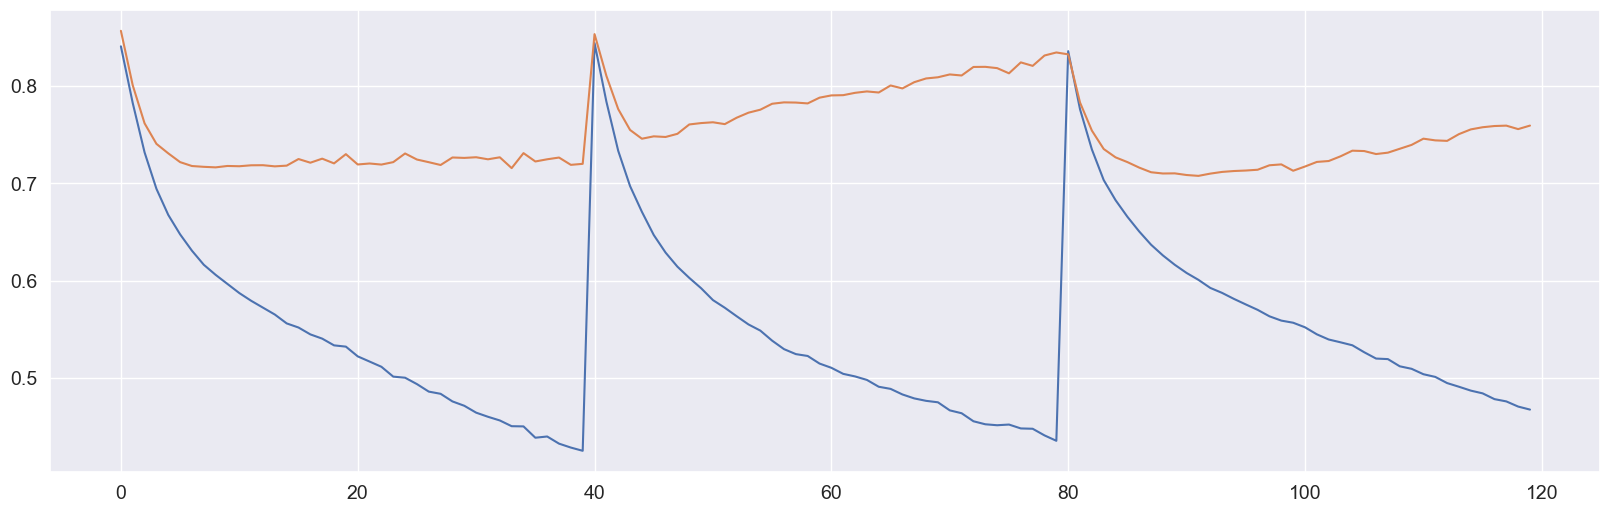

In [51]:
plt.figure(figsize=(20,6))
plt.plot(eval_scores['loss_train'])
plt.plot(eval_scores['loss_test'])

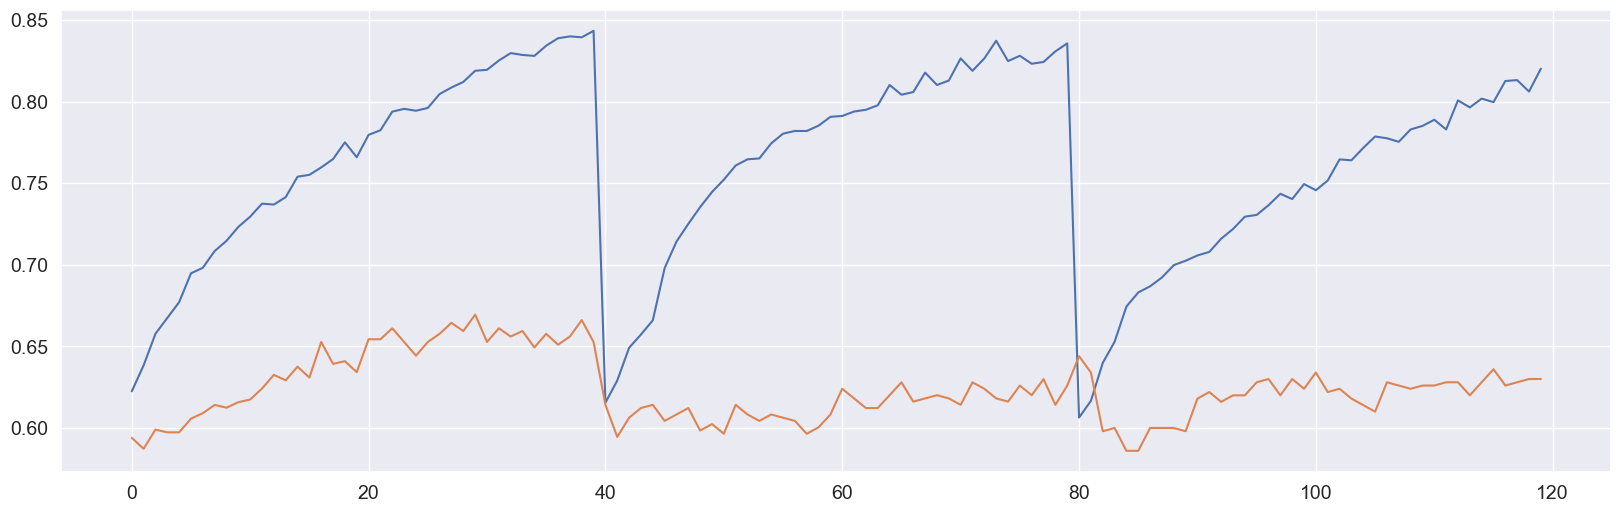

In [52]:
plt.figure(figsize=(20,6))
plt.plot(eval_scores['acc_train'])
plt.plot(eval_scores['acc_test'])

In [31]:
pd.DataFrame(scores.T, columns=['test_acc', 'test_rec_macro',
                                'test_prec_macro', 'test_loss',
                                'test_f1', 'test_roc_auc']).to_csv('/Users/rodrigo/Post-Grad/CC400/Results/GAT.csv')